In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('./data/ICLR-2017-18-19-21.csv')
data.info()
abstract = list(data.ABSTRACT)
title = list(data.TITLE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YEAR          1497 non-null   int64  
 1   TITLE         1497 non-null   object 
 2   Authors       1497 non-null   object 
 3   Paper Link    1497 non-null   object 
 4   ABSTRACT      1497 non-null   object 
 5   Affiliations  1497 non-null   object 
 6   Citations     1497 non-null   object 
 7   Unnamed: 7    1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 93.7+ KB


In [3]:
data.head(4)

,YEAR,TITLE,Authors,Paper Link,ABSTRACT,Affiliations,Citations,Unnamed: 7
0,2017,Making Neural Programming Architectures Genera...,"Jonathon Cai, Richard Shin, Dawn Song",https://openreview.net/forum?id=BkbY4psgg&note...,"Empirically, neural networks that attempt to l...","['University of California, Berkeley']",113,NaN
1,2017,End-to-end Optimized Image Compression,"Johannes Ballé, Valero Laparra, Eero P. Simonc...",https://openreview.net/forum?id=rJxdQ3jeg&note...,"We describe an image compression method, consi...","['New York University', 'RWTH Aachen', uv.es]",706,NaN
2,2017,Optimization as a Model for Few-Shot Learning,"Sachin Ravi, Hugo Larochelle",https://openreview.net/forum?id=rJY0-Kcll&note...,Though deep neural networks have shown great s...,"['Princeton University', 'Twitter', 'Universit...",1838,NaN
3,2017,Learning End-to-End Goal-Oriented Dialog,"Antoine Bordes, Y-Lan Boureau, Jason Weston",https://openreview.net/forum?id=S1Bb3D5gg&note...,Traditional dialog systems used in goal-orient...,"['Google', 'Centre national de la recherche sc...",699,NaN


In [4]:
samples = data.sample(4)
for _, s in samples.iterrows():
    print(f"{s.TITLE} (ICLR{s.YEAR})")
    print(f"Abstract: {s.ABSTRACT}\n")

FedMix: Approximation of Mixup under Mean Augmented Federated Learning (ICLR2021)
Abstract: Federated learning (FL) allows edge devices to collectively learn a model without directly sharing data within each device, thus preserving privacy and eliminating the need to store data globally. While there are promising results under the assumption of independent and identically distributed (iid) local data, current state-of-the-art algorithms suffer a performance degradation as the heterogeneity of local data across clients increases. To resolve this issue, we propose a simple framework, \emph{Mean Augmented Federated Learning (MAFL)}, where clients send and receive \emph{averaged} local data, subject to the privacy requirements of target applications. Under our framework, we propose a new augmentation algorithm, named \emph{FedMix}, which is inspired by a phenomenal yet simple data augmentation method, Mixup, but does not require local raw data to be directly shared among devices. Our metho

In [5]:
sw = nltk.corpus.stopwords.words('english')
sw.extend(['from', 'subject', 'using', 'via', 'new', 'work', 'different', 'introduce', 'existing', 'github', 'available', 'also', 'use', 'used', 'without', "propose", "improve",\
    "novel", "better", "extensive", "well", "eg", "however", "method", "proposed", \
    "'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'])

In [6]:
import string
puncs = dict.fromkeys(string.punctuation)
del puncs["-"]
table = str.maketrans(puncs)
# pre-process
lemm = nltk.WordNetLemmatizer()
abstract_proc = []
for i in range(len(abstract)):
    ab = abstract[i].strip().lower().translate(table).split()
    abstract_proc.append([lemm.lemmatize(w) for w in ab])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tf_vectorizer = CountVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tf = tf_vectorizer.fit_transform(abstract_proc)

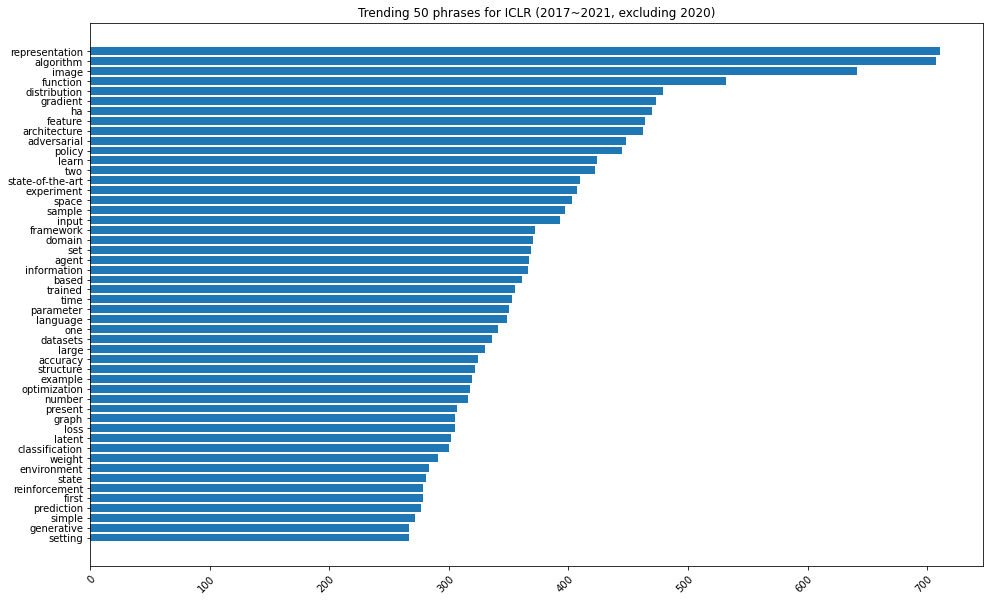

In [7]:
feature_count = pd.DataFrame({
    "feat_name": tf_vectorizer.get_feature_names_out(),
    "feat_count": tf.toarray().sum(axis=0).tolist()
})

vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(16, 10))

ax.barh(y=np.flip(vals_to_display.feat_name.values), width=np.flip(vals_to_display.feat_count.values))
ax.set_title("Trending 50 phrases for ICLR (2017~2021, excluding 2020)")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

In [8]:
diversity_papers = data.loc[:, ("TITLE", "YEAR")]
diversity_papers["n_themes"] = diversity_papers.index.values
diversity_papers["n_themes"] = diversity_papers["n_themes"].apply(lambda row: np.nonzero(tf[row,:])[1].tolist())

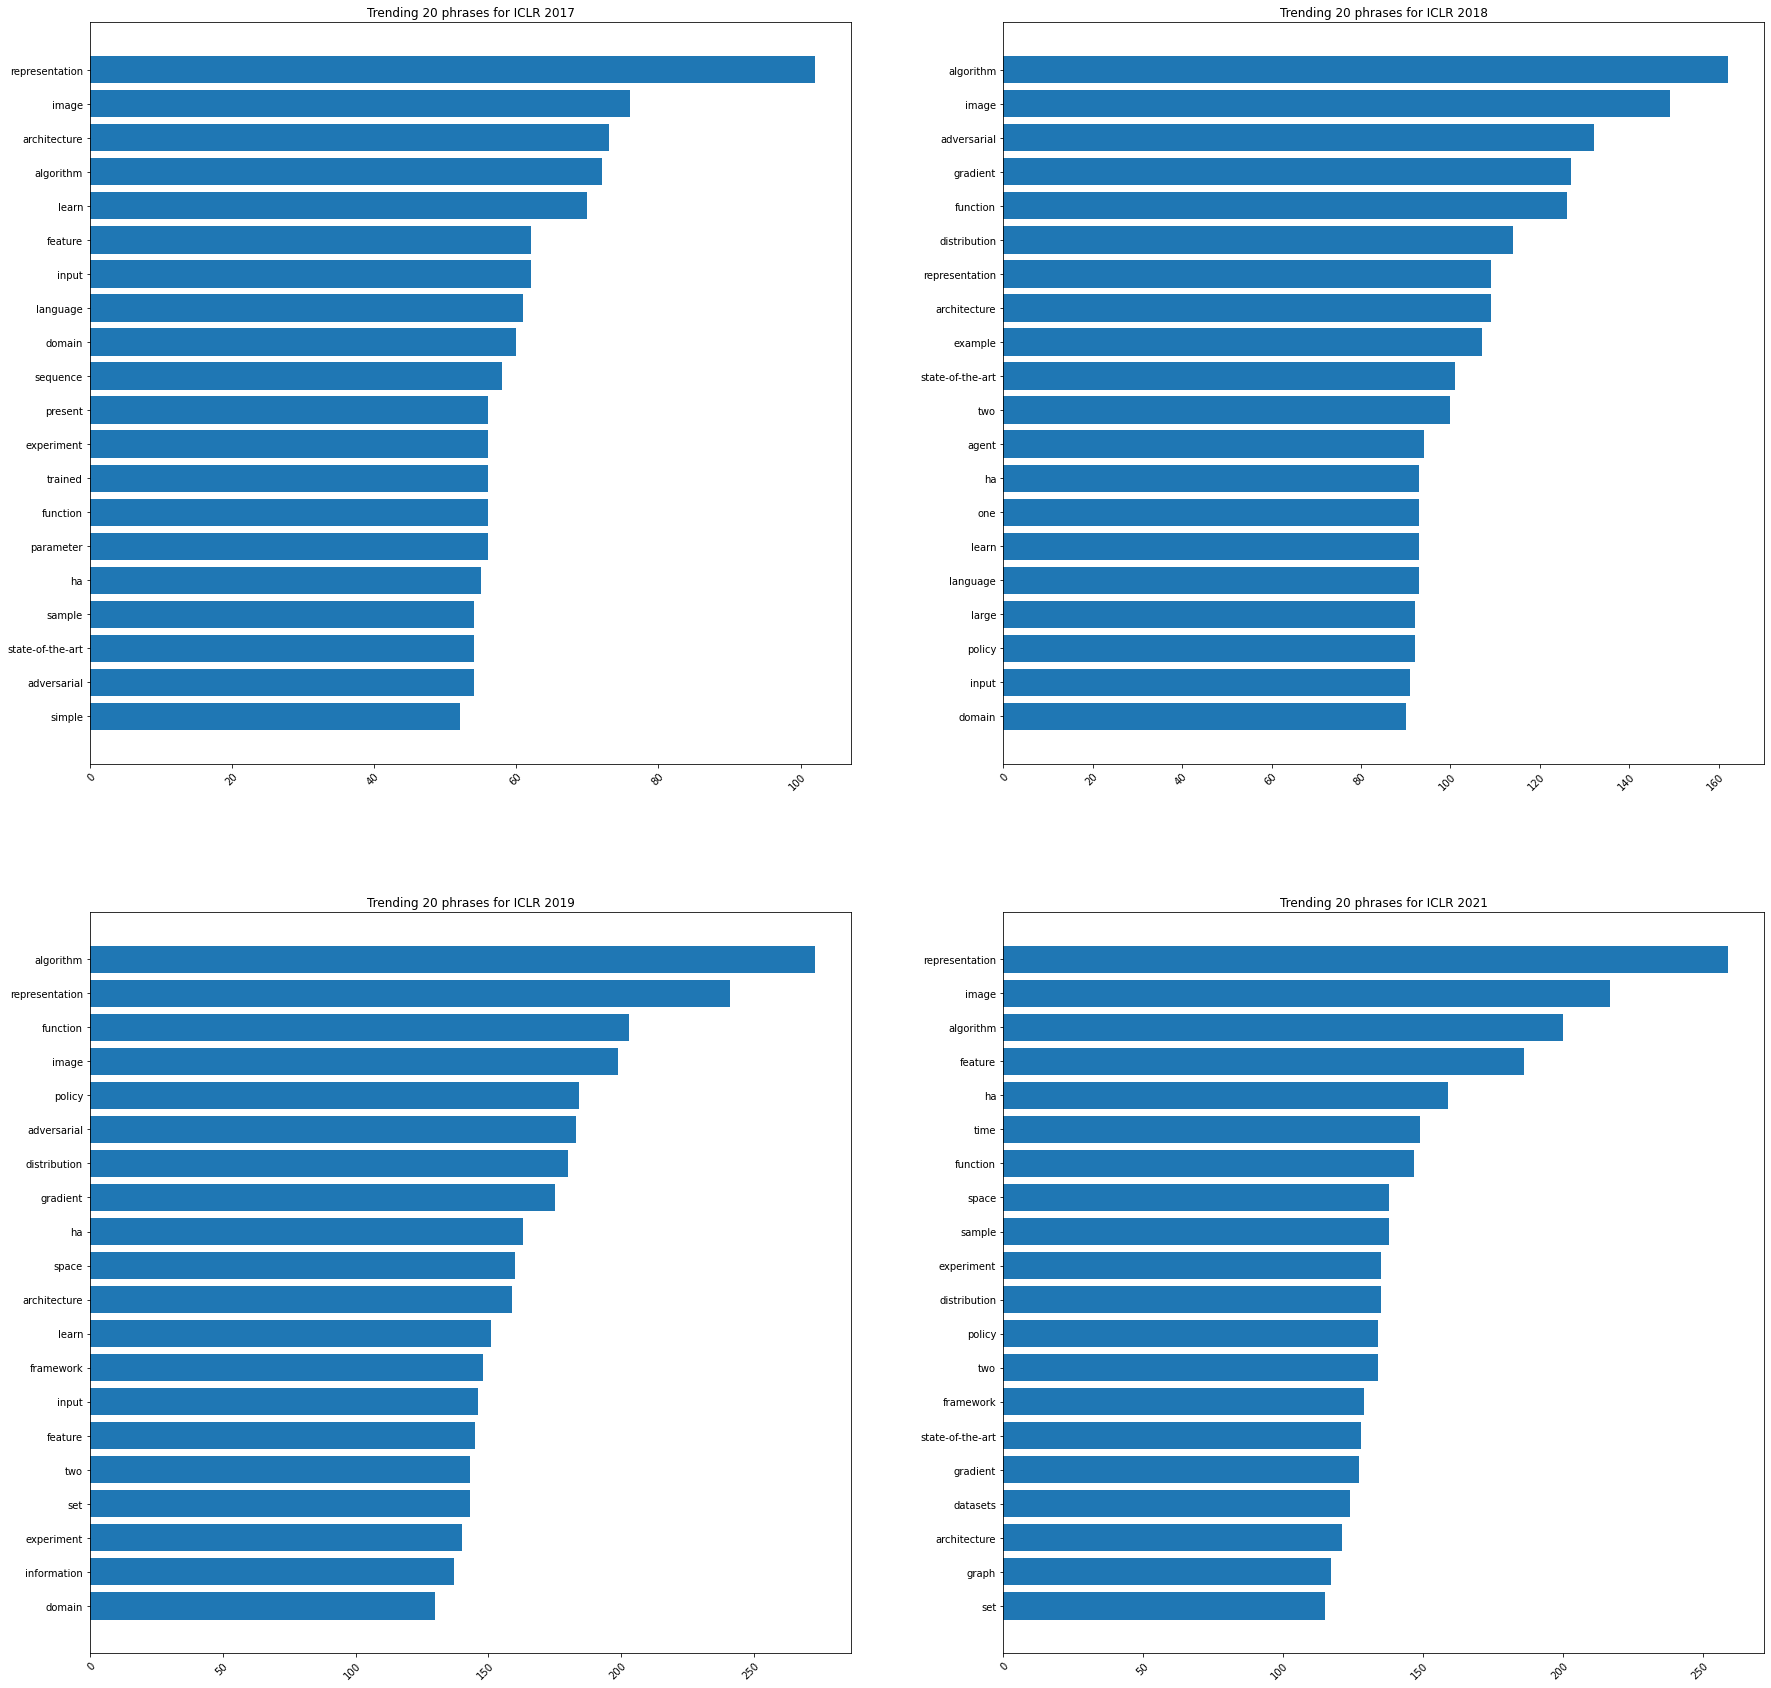

In [9]:
def get_trend_n_year(year, n):
    freq = tf.toarray()[np.where(np.array(data.YEAR)==year)[0], :].sum(0)
    word_inds = np.flip(np.argsort(freq))[:n]
    return tf_vectorizer.get_feature_names_out()[word_inds], freq[word_inds]

top_n = 20
fig, axes = plt.subplots(2, 2, figsize=(30, 30))
ax_count = 0
for year in range(2017, 2022):
    ax = axes.reshape(-1)[ax_count]
    if year == 2020:
        continue
    names, counts = get_trend_n_year(year, top_n)
    ax.barh(y=np.flip(names), width=np.flip(counts))
    ax.set_title(f"Trending {top_n} phrases for ICLR {year}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    ax_count += 1

plt.show()

In [10]:
#number of topics
n_topics=6

from sklearn.decomposition import LatentDirichletAllocation
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', 
                                learning_offset=50., random_state=444, verbose=0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [11]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [12]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if isinstance(temp_vector_sum, int):
            print(topic)
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            try:
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            except:
                pass
        top_words.append(" ".join(topic_words))         
    return top_words

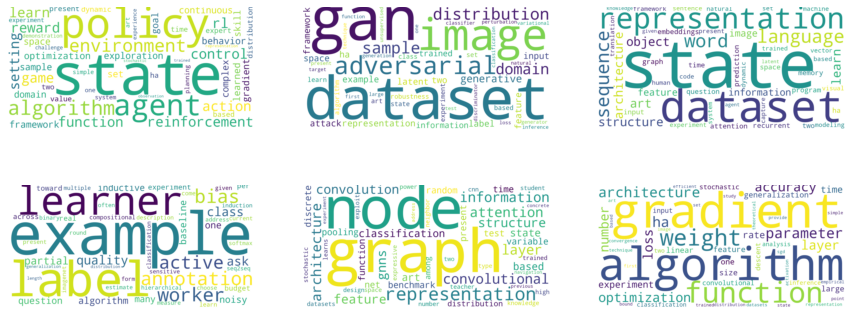

In [13]:
# Printing words from each topic
top_n_words = get_top_n_words(50, lda_keys, tf, tf_vectorizer)

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for tw, ax in zip(top_n_words, axes.reshape(-1)):
    wc = WordCloud(background_color="white", width=1600, height=800)
    wc.generate(tw)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
plt.show()

In [14]:
from sklearn.manifold import TSNE
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1497 samples in 0.001s...
[t-SNE] Computed neighbors for 1497 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1497
[t-SNE] Computed conditional probabilities for sample 1497 / 1497
[t-SNE] Mean sigma: 0.004764
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.146999
[t-SNE] KL divergence after 2000 iterations: 0.385889


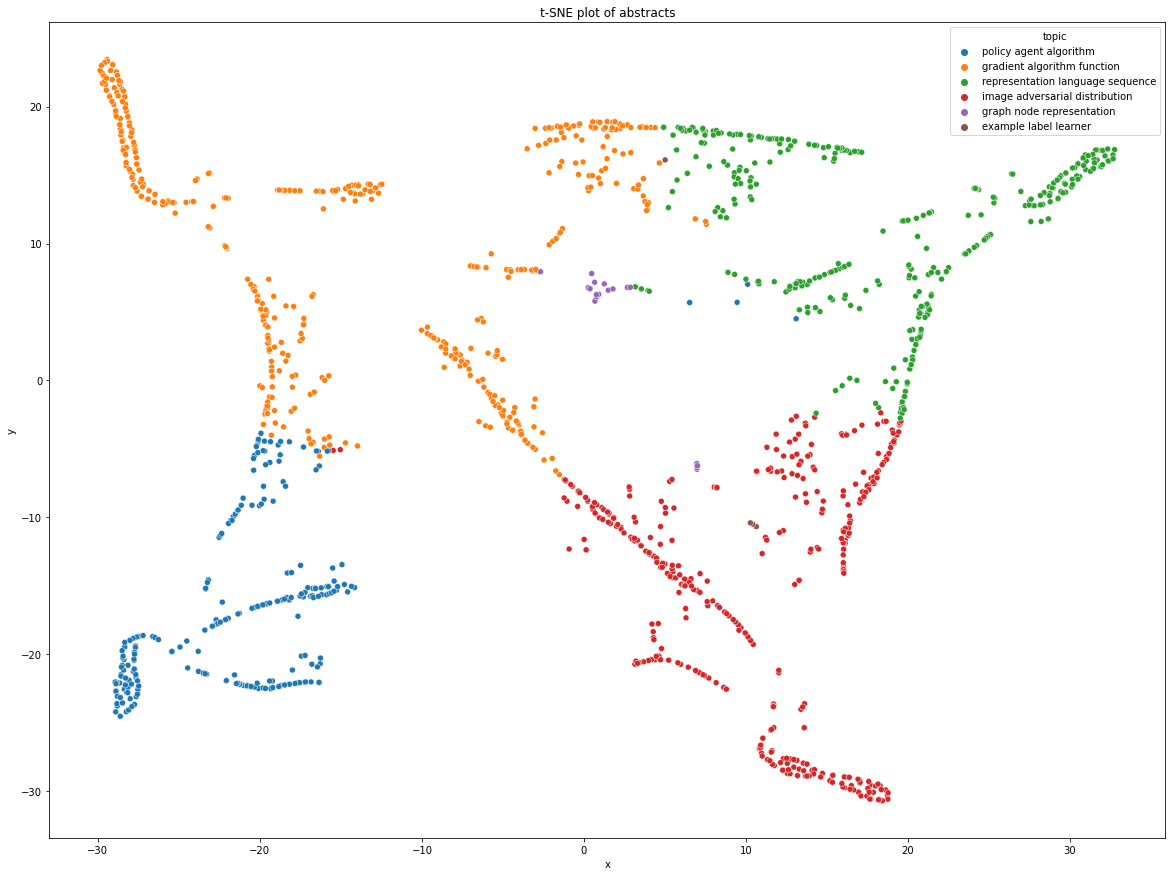

In [15]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

hue = []
for k in lda_keys:
    hue.append(top_3_words_lda[k])

disp_data = pd.DataFrame({'x': pd.Series(tsne_lda_vectors[:,0]), 'y': pd.Series(tsne_lda_vectors[:,1]), 'topic': pd.Series(hue)})
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(data=disp_data, x='x', y='y', hue='topic', ax=ax)
ax.set_title("t-SNE plot of abstracts")
plt.show()

In [16]:
for n in range(5):
    topic_most_pr = lda_topic_matrix[n].argsort()[-2:]
    print("Paper #{}: {}\n - top 2 topic: ({})+({})\n".format(n,title[n], top_3_words_lda[topic_most_pr[0]], top_3_words_lda[topic_most_pr[1]]))

Paper #0: Making Neural Programming Architectures Generalize via Recursion
 - top 2 topic: (representation language sequence)+(policy agent algorithm)

Paper #1: End-to-end Optimized Image Compression
 - top 2 topic: (image adversarial distribution)+(gradient algorithm function)

Paper #2: Optimization as a Model for Few-Shot Learning
 - top 2 topic: (policy agent algorithm)+(gradient algorithm function)

Paper #3: Learning End-to-End Goal-Oriented Dialog
 - top 2 topic: (image adversarial distribution)+(representation language sequence)

Paper #4: Towards Principled Methods for Training Generative Adversarial Networks
 - top 2 topic: (image adversarial distribution)+(gradient algorithm function)



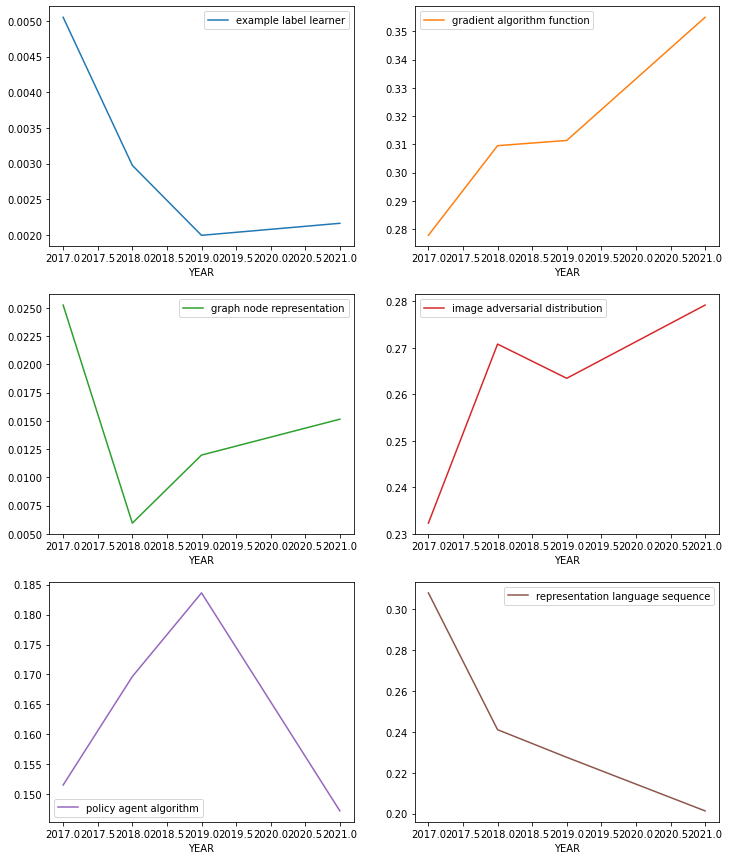

In [17]:
plt.rcParams['figure.figsize'] = (12,15)
lda_topics = [top_3_words_lda[k] for k in lda_keys]
# pd.crosstab(df_new['YEAR'], df_new['Dominant_Topic'], normalize='index').plot.bar(stacked=True)
pd.crosstab(data['YEAR'].astype(int), pd.Series(lda_topics).astype('category'), normalize='index').plot(kind='line', subplots=True, sharex=False, layout=(3, 2))
plt.show()

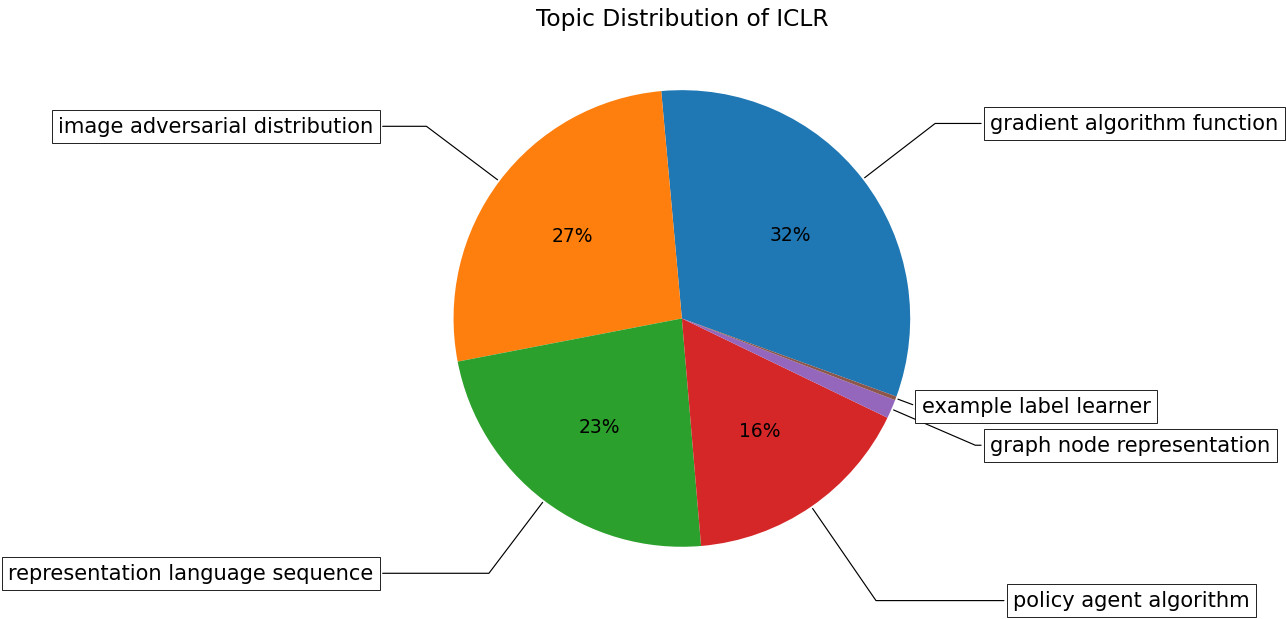

In [18]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

inds = np.flip(np.argsort(lda_counts))

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"), dpi=84)

values = np.array(lda_counts)[inds]
labels = np.array(top_3_words_lda)[lda_categories][inds]

# wedges, texts = ax.pie(np.array(lda_counts)[inds], wedgeprops=dict(width=1.0), startangle=-20)
wedges, texts, _ = ax.pie(values, wedgeprops=dict(width=1.0), startangle=-20, autopct=make_autopct(values), textprops={'fontsize': 16})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0, -0.3][i-3] if i > 2 else 0.0
    ax.annotate(labels[i], xy=(x, y), xytext=((1.35+offset)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title("Topic Distribution of ICLR", fontsize=20)

plt.show()

In [101]:
title_proc = []
for i in range(len(title)):
    t = title[i].strip().lower().translate(table).split()
    title_proc.append([lemm.lemmatize(w) for w in t])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tv = tfidf_vectorizer.fit_transform(title_proc)
tv_norm = normalize(tv, axis=1)

In [102]:
from scipy.spatial.distance import jensenshannon as js
def find_n_related(inp_t, inp_ab, n, alpha=0.5):
    assert isinstance(inp_t, str)
    assert isinstance(inp_ab, str)
    # preprocess
    t_proc = inp_t.strip().lower().translate(table).split()
    ab_proc = inp_ab.strip().lower().translate(table).split()
    t_proc = [lemm.lemmatize(w) for w in t_proc]
    ab_proc = [lemm.lemmatize(w) for w in ab_proc]

    t_vec = tfidf_vectorizer.transform([t_proc]).toarray()
    t_vec = normalize(t_vec, axis=1)
    # print(t_vec.shape)
    t_scores = np.matmul(tv_norm.toarray(), t_vec.T).squeeze()

    ab_vec = tf_vectorizer.transform([ab_proc]).toarray()
    logits = lda.transform(ab_vec)
    # ab_scores = np.matmul(lda_topic_matrix, logits.T).squeeze()
    ab_scores = 1 - np.array([js(v.squeeze(), logits.squeeze(), 2) for v in lda_topic_matrix])

    scores = alpha * t_scores + (1-alpha) * ab_scores
    inds = np.flip(np.argsort(scores))[:n]
    retrieved = data.loc[inds, :]
    retrieved["Score"] = scores[inds]

    return retrieved

In [103]:
# Temporal Localization of Moments in Video Collections with Natural Language (ICCV2019)
# https://arxiv.org/abs/1907.12763
test_t = "Temporal Localization of Moments in Video Collections with Natural Language"
test_abs = """In this paper, we introduce the task of retrieving relevant video moments from a large corpus of untrimmed, unsegmented videos given a natural language query.
Our task poses unique challenges as a system must efficiently identify both the relevant videos and localize the relevant moments in the videos.
This task is in contrast to prior work that localizes relevant moments in a single video or searches a large collection of already-segmented videos.
For our task, we introduce Clip Alignment with Language (CAL), a model that aligns features for a natural language query to a sequence of short video clips that compose a candidate moment in a video.
Our approach goes beyond prior work that aggregates video features over a candidate moment by allowing for finer clip alignment.
Moreover, our approach is amenable to efficient indexing of the resulting clip-level representations, which makes it suitable for moment localization in large video collections.
We evaluate our approach on three recently proposed datasets for temporal localization of moments in video with natural language extended to our video corpus moment retrieval setting: DiDeMo, Charades-STA, and ActivityNet-captions.
We show that our CAL model outperforms the recently proposed Moment Context Network (MCN) on all criteria across all datasets on our proposed task, obtaining an 8%-85% and 11%-47% boost for average recall and median rank, respectively,
and achieves 5x faster retrieval and 8x smaller index size with a 500K video corpus."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICLR{s.YEAR}): {s.Score:.3f}")

Structured Prediction as Translation between Augmented Natural Languages (ICLR2021): 0.596
Decomposing Motion and Content for Natural Video Sequence Prediction (ICLR2017): 0.594
On Learning Universal Representations Across Languages (ICLR2021): 0.583
Learning to Count Objects in Natural Images for Visual Question Answering (ICLR2018): 0.582
Unsupervised Representation Learning for Time Series with Temporal Neighborhood Coding (ICLR2021): 0.574
GLUE: A Multi-Task Benchmark and Analysis Platform for Natural Language Understanding (ICLR2019): 0.558
Learning a Natural Language Interface with Neural Programmer (ICLR2017): 0.552
LeMoNADe: Learned Motif and Neuronal Assembly Detection in calcium imaging videos (ICLR2019): 0.551
Representation Degeneration Problem in Training Natural Language Generation Models (ICLR2019): 0.506
Representation learning for improved interpretability and classification accuracy of clinical factors from EEG (ICLR2021): 0.498


In [104]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16955 (AAAI2021)
test_t = "Adversarial Defence by Diversified Simultaneous Training of Deep Ensembles"
test_abs = """Learning-based classifiers are susceptible to adversarial examples. Existing defence methods are mostly devised on individual classifiers.
Recent studies showed that it is viable to increase adversarial robustness by promoting diversity over an ensemble of models.
In this paper, we propose adversarial defence by encouraging ensemble diversity on learning high-level feature representations and gradient dispersion in simultaneous training of deep ensemble networks.
We perform extensive evaluations under white-box and black-box attacks including transferred examples and adaptive attacks.
Our approach achieves a significant gain of up to 52% in adversarial robustness, compared with the baseline and the state-of-the-art method on image benchmarks with complex data scenes.
The proposed approach complements the defence paradigm of adversarial training, and can further boost the performance. The source code is available at https://github.com/ALIS-Lab/AAAI2021-PDD."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICLR{s.YEAR}): {s.Score:.3f}")

Ensemble Adversarial Training: Attacks and Defenses (ICLR2018): 0.701
Multi-Domain Adversarial Learning (ICLR2019): 0.627
Mitigating Adversarial Effects Through Randomization (ICLR2018): 0.604
The Limitations of Adversarial Training and the Blind-Spot Attack (ICLR2019): 0.603
Adversarial Reprogramming of Neural Networks (ICLR2019): 0.572
Certifying Some Distributional Robustness with Principled Adversarial Training (ICLR2018): 0.568
SPIGAN: Privileged Adversarial Learning from Simulation (ICLR2019): 0.567
Shape-Texture Debiased Neural Network Training (ICLR2021): 0.557
Neural Photo Editing with Introspective Adversarial Networks (ICLR2017): 0.551
A Direct Approach to Robust Deep Learning Using Adversarial Networks (ICLR2019): 0.551


In [105]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16815 (AAAI2021)
test_t = "Learning Invariant Representations using Inverse Contrastive Loss"
test_abs = """Learning invariant representations is a critical first step in a number of machine learning tasks.
A common approach is given by the so-called information bottleneck principle in which an application dependent function of mutual information is carefully chosen and optimized.
Unfortunately, in practice, these functions are not suitable for optimization purposes since these losses are agnostic of the metric structure of the parameters of the model.
In our paper, we introduce a class of losses for learning representations that are invariant to some extraneous variable of interest by inverting the class of contrastive losses, i.e., inverse contrastive loss (ICL).
We show that if the extraneous variable is binary, then optimizing ICL is equivalent to optimizing a regularized MMD divergence.
More generally, we also show that if we are provided a metric on the sample space, our formulation of ICL can be decomposed into a sum of convex functions of the given distance metric.
Our experimental results indicate that models obtained by optimizing ICL achieve significantly better invariance to the extraneous variable for a fixed desired level of accuracy.
In a variety of experimental settings, we show applicability of ICL for learning invariant representations for both continuous and discrete protected/extraneous variables.
The project page with code is available at https://github.com/adityakumarakash/ICL"""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (ICLR{s.YEAR}): {s.Score:.3f}")

Active Contrastive Learning of Audio-Visual Video Representations (ICLR2021): 0.653
Central Moment Discrepancy (CMD) for Domain-Invariant Representation Learning (ICLR2017): 0.608
Analyzing Inverse Problems with Invertible Neural Networks (ICLR2019): 0.530
Conditional Negative Sampling for Contrastive Learning of Visual Representations (ICLR2021): 0.529
Meta-Learning Update Rules for Unsupervised Representation Learning (ICLR2019): 0.519
Representation Learning via Invariant Causal Mechanisms (ICLR2021): 0.516
Prototypical Contrastive Learning of Unsupervised Representations (ICLR2021): 0.513
What Should Not Be Contrastive in Contrastive Learning (ICLR2021): 0.503
Improving MMD-GAN Training with Repulsive Loss Function (ICLR2019): 0.502
Deep Decoder: Concise Image Representations from Untrained Non-convolutional Networks (ICLR2019): 0.501


In [106]:
import pickle
with open("./saved_models/lda_iclr.pickle", 'wb') as f:
    pickle.dump(lda, f)

In [107]:
np.save("./saved_models/matrix_iclr.npy", lda_topic_matrix)